In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from tqdm import tqdm


from full_dynamics import FullSimulation

## Surface Phase Diagram

In [2]:
def asymmetry(dist):
    rho = dist[1:-1]
    return np.sum(np.abs(rho - np.roll(np.flip(rho), +1)))*(12/500) / (12*2*(np.mean(rho) - np.min(rho)))

def concentration(dist):
    rho = np.concatenate((dist[1:150], dist[350:-1]))
    return np.sum((rho - np.mean(rho))**2) * (12/500)

In [3]:
data = np.load('data/combined_sweep_data.npz', allow_pickle=True)
Pe = data['Pe']
epsilon = data['epsilon']
epsilons = data['epsilon']
rho_history = data['rho_history']
final_rho = rho_history[:, -1, :]
#final_f = data['final_f']

In [4]:
def calc_critical_epsilon(Pe_val, n = 3, AS_min = 10**(-3)):
    indices_Pe_val = np.where(Pe == Pe_val)[0]

    filtered_rho_history = rho_history[indices_Pe_val]
    filtered_epsilons = epsilons[indices_Pe_val]
    sorted_indices = np.argsort(filtered_epsilons)
    sorted_rho_history = filtered_rho_history[sorted_indices]
    history_AS = [[asymmetry(rho) for rho in history] for history in sorted_rho_history]

    indices_crit = [np.argmax(np.array(history) > AS_min) for history in history_AS]
    grad_crit = [(history[i+1] - history[i]) * 2 / history[i] if i != 0 else 0 for history, i in zip(history_AS, indices_crit)]


    non_zero_indices = [i for i, val in enumerate(grad_crit) if (val != 0 and filtered_epsilons[i] < 10)]
    last_few_indices = non_zero_indices[-n:]
    last_few_grad_crit = [grad_crit[i] for i in last_few_indices]
    last_few_epsilons = [filtered_epsilons[i] for i in last_few_indices]

    coefficients = np.polyfit(last_few_epsilons, last_few_grad_crit, 1)
    slope, intercept = coefficients

    x_intercept = -intercept / slope
    return x_intercept

In [5]:
epsilons = data['epsilon']
Pe = data['Pe']

2033it [00:09, 208.97it/s]


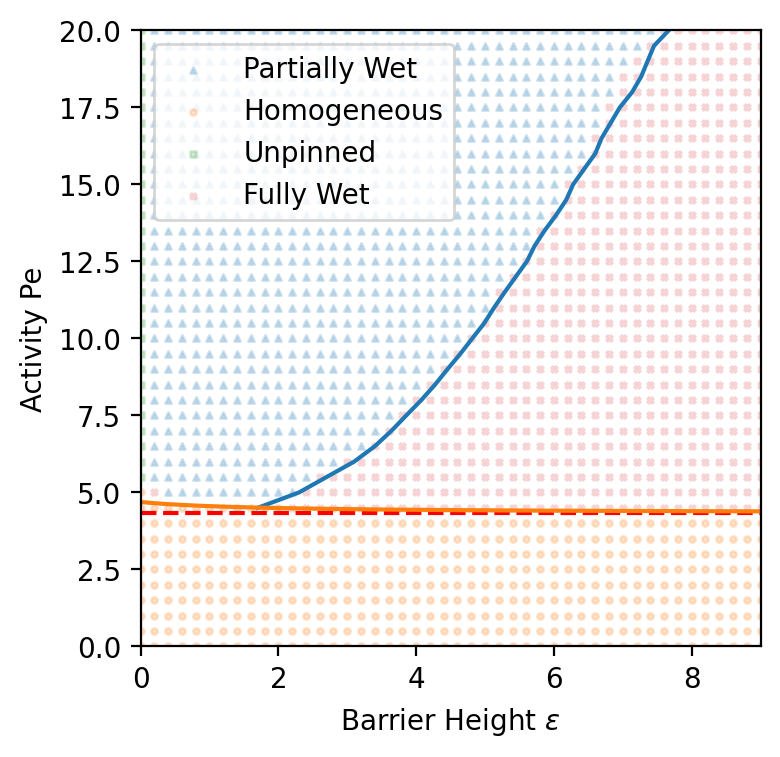

In [6]:


classification_list = []
def classifify(final_rho, rho_hist, epsilon):
    AS_hist = [asymmetry(rho) for rho in rho_hist]
    AS = asymmetry(final_rho)
    if concentration(final_rho) <= 0.01:
        return 1 #homogeneous
    elif epsilon == 0.0:
        return 2
    elif AS_hist[-1] >= 10**(-3) or (AS_hist[-1] - AS_hist[-2]) > 10**(-2):
        return 0 #PW
    else:
        return 3 #FW
    
classification_list = []

for rho, rho_hist, epsilon in tqdm(zip(final_rho, rho_history, epsilons)):
    classification = classifify(rho, rho_hist, epsilon)
    classification_list.append(classification)

critical_vals = []
for Pe_val in np.linspace(6.0, 20.0, 29):
    n=3
    AS_min = 0.5*10**(-2)
    critical_vals.append(calc_critical_epsilon(Pe_val, AS_min = AS_min, n = n))

plt.figure(figsize=(4,4), dpi = 200)

plt.xlabel(r'Barrier Height $\epsilon$')
plt.ylabel('Activity Pe')

states_list = ['Partially Wet', 'Homogeneous', 'Unpinned', 'Fully Wet']
#plt.scatter(epsilon, Pe, c=classification_list, cmap='coolwarm', s=10)
shapes = {0: '^', 1: 'o', 2: 's', 3: 'x'}
for state in set(classification_list):
    indices = [i for i, c in enumerate(classification_list) if c == state]
    plt.scatter(epsilons[indices], Pe[indices], label=states_list[state], marker=shapes[state], s=5, alpha=0.2)
plt.legend(loc='upper left')
plt.xlim(0, 9)
plt.ylim(0, 20)
plt.hlines(4.33, 0, 9, color='red', linestyle='--')



FW_epsilons = np.concatenate(([1.7, 2.3, 2.7, 3.1, 3.4], critical_vals[2:]))
FW_Pes = np.linspace(4.5, 20.0, 32)
plt.plot(FW_epsilons, FW_Pes)
x = np.linspace(0, 10, 500)
y_1 = 4.33 + 0.9/(1.5*x+2.5)

#y_2 = np.maximum(4.33 + 0.9/(x+2.5), 3.5 * x - 7)

plt.plot(x, y_1)
#plt.plot(x, y_2)

## Wetting Line Cartoon

In [7]:
# Filter indices where Pe equals 10.0
indices_Pe_val = np.where(Pe == 5.0)[0]

filtered_rho_history = rho_history[indices_Pe_val]
filtered_epsilons = epsilons[indices_Pe_val]
sorted_indices = np.argsort(filtered_epsilons)
sorted_rho_history = filtered_rho_history[sorted_indices]
history_AS = [[asymmetry(rho) for rho in history] for history in sorted_rho_history]

indices_crit = [np.argmax(np.array(history) > 10**(-3)) for history in history_AS]


<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:42: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:42: SyntaxWarning: invalid escape sequence '\e'
/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_98832/1680548484.py:35: SyntaxWarning: invalid escape sequence '\e'
  axs[1].set_title('(b) Fitting $\epsilon^*$ for Pe=10')
/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_98832/1680548484.py:42: SyntaxWarning: invalid escape sequence '\e'
  axs[1].vlines(x_intercept, 0, 0.6, color='green', linestyle='--', label=f'$\epsilon^*$-intercept: {x_intercept:.2f}')


(0.0, 0.6)

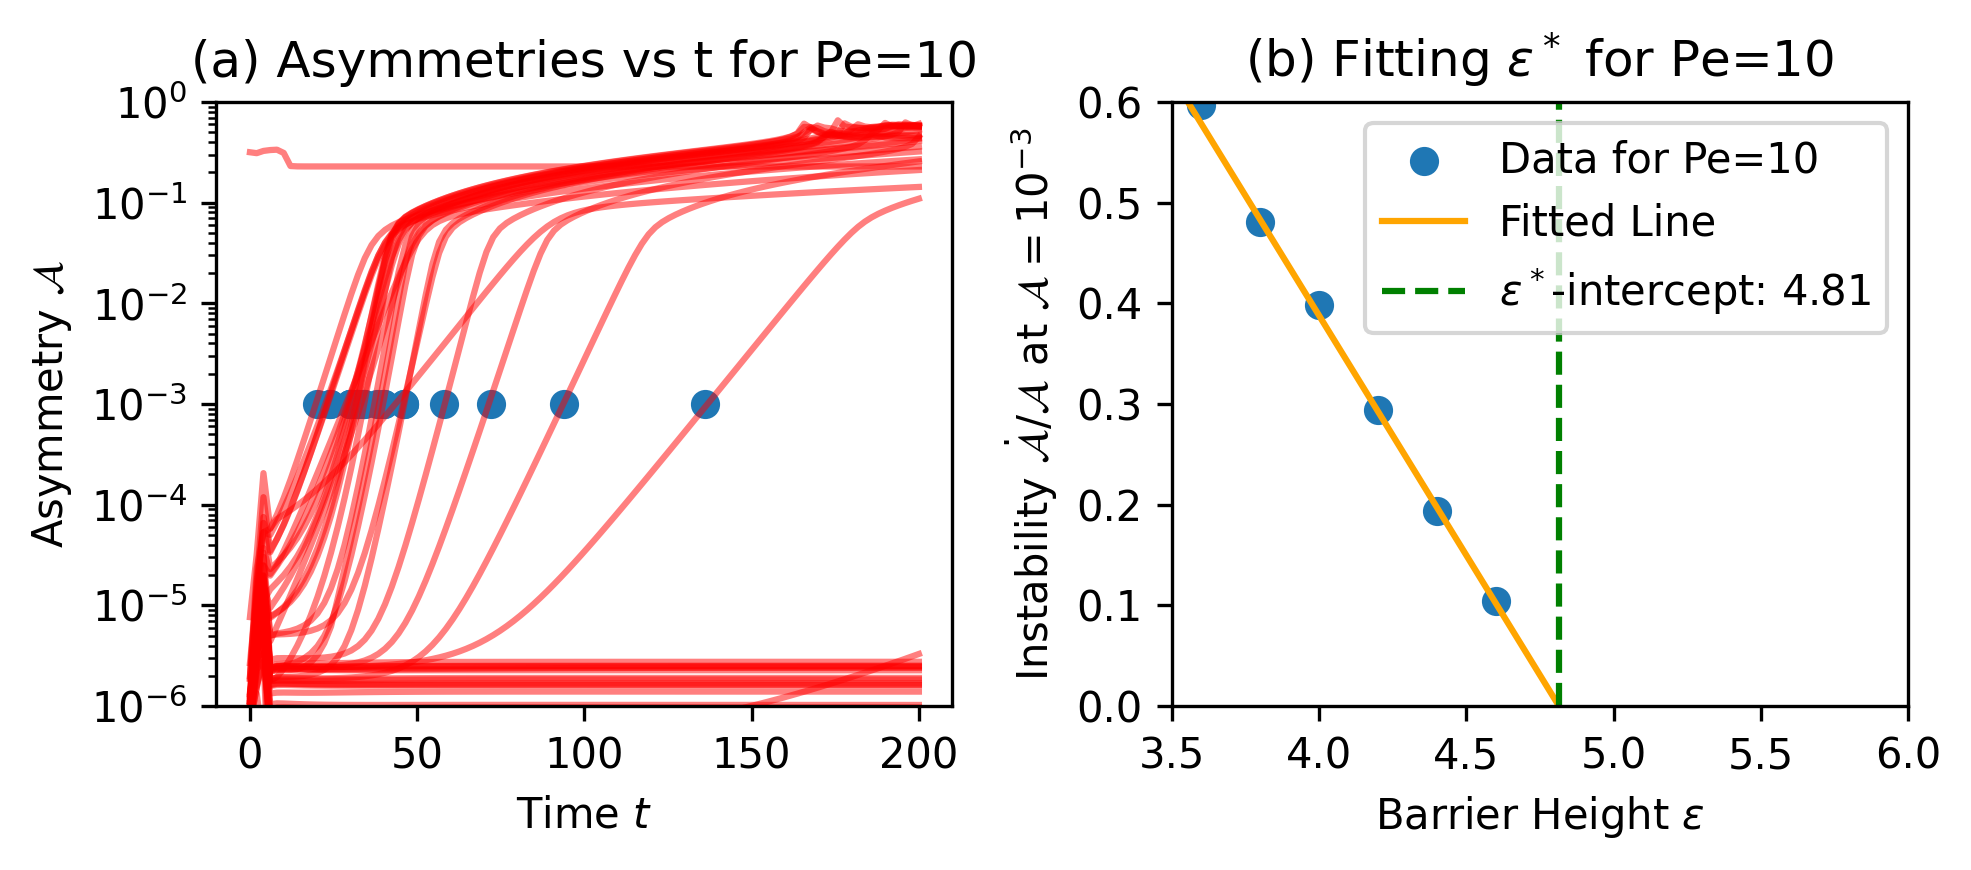

In [8]:
# Filter indices where Pe equals 10.0
indices_Pe_val = np.where(Pe == 10.0)[0]

filtered_rho_history = rho_history[indices_Pe_val]
filtered_epsilons = epsilons[indices_Pe_val]
sorted_indices = np.argsort(filtered_epsilons)
sorted_rho_history = filtered_rho_history[sorted_indices]
history_AS = [[asymmetry(rho) for rho in history] for history in sorted_rho_history]

indices_crit = [np.argmax(np.array(history) > 10**(-3)) for history in history_AS]
grad_crit = [((history[i+1] - history[i])/2 * 1/history[i] ) if i != 0 else 0 for history, i in zip(history_AS, indices_crit)]
non_zero_indices = [i for i, val in enumerate(grad_crit) if (val != 0 and filtered_epsilons[i] < 10)]
last_few_indices = non_zero_indices[-3:]
last_few_grad_crit = [grad_crit[i] for i in last_few_indices]
last_few_epsilons = [filtered_epsilons[i] for i in last_few_indices]

fig, axs = plt.subplots(1, 2, figsize=(6.67, 3.0), dpi=300, tight_layout=True)

for hisAS in history_AS:
    axs[0].plot(np.linspace(0, 200, 100), hisAS, color='red', alpha=0.5)
axs[0].set_yscale('log')
indices_crit = [np.argmax(np.array(history) > 10**(-3)) for history in history_AS]
axs[0].scatter(2*(np.array(indices_crit))[4:-26], 10**(-3) + 0*np.array(indices_crit)[4:-26])
axs[0].set_title('(a) Asymmetries vs t for Pe=10')
axs[0].set_xlabel(r'Time $t$')
axs[0].set_ylabel(r'Asymmetry $\mathcal{A}$')
axs[0].set_ylim(10**(-6), 10**(0))


axs[1].scatter(filtered_epsilons[:-26], grad_crit[:-26], label='Data for Pe=10')
axs[1].set_xlim(3.5,6)
axs[1].set_ylim(0,0.6)
axs[1].set_xlabel(r'Barrier Height $\epsilon$')
axs[1].set_ylabel(r'Instability $\dot{\mathcal{A}}/\mathcal{A}$ at $\mathcal{A} = 10^{-3}$')
axs[1].set_title('(b) Fitting $\epsilon^*$ for Pe=10')
coefficients = np.polyfit(last_few_epsilons, last_few_grad_crit, 1)
slope, intercept = coefficients
x_intercept = -intercept / slope
x_fit = np.linspace(3, x_intercept, 100)
y_fit = slope * x_fit + intercept
axs[1].plot(x_fit, y_fit, label='Fitted Line', color='orange')
axs[1].vlines(x_intercept, 0, 0.6, color='green', linestyle='--', label=f'$\epsilon^*$-intercept: {x_intercept:.2f}')
axs[1].legend()
axs[1].set_ylim(bottom=0)

#plt.savefig('fig_wetting_calc', dpi=600, bbox_inches='tight')


## Steady-States

Part 1: Distrubutions in SS

In [9]:
'''Us = []
Vs = []
heatmaps = []
rhos = []

for epsilon, v_0 in zip([8.0, 1.0, 1.0, 0.0], [10, 10, 3, 10]):
    test_f = FullSimulation(N_x=300, N_theta = 30, v_0 = v_0, L_x = 10, epsilon = epsilon, hump_width=0.5)
    test_f.set_random(0.6, 0.01)
    if epsilon==1.0 and v_0 == 10:
        test_f.evolve(200.0, show_progress=True)
    else:
        test_f.evolve(50.0, show_progress=True)


    F_x, F_theta = test_f.eval_flux()

    # Heatmap data (scalar field)
    heatmap_data = test_f.f.T

    # Arrow data (vector field)
    U = F_x.T  # x-component of the vector
    V = F_theta[:-1, :].T   # y-component of the vector

    Us.append(U)
    Vs.append(V)
    heatmaps.append(heatmap_data)
    rhos.append(test_f.history_rho[-1])

N_x1, N_x2 = 299, 30  # Grid size
x1 = np.linspace(0, 10, N_x1)
x2 = np.linspace(0, 2*np.pi, N_x2)
X1, X2 = np.meshgrid(x1, x2)

np.savez('heatmap_data.npz', Us=Us, Vs=Vs, heatmaps=heatmaps, rhos=rhos, x1=x1, x2=x2)'''

"Us = []\nVs = []\nheatmaps = []\nrhos = []\n\nfor epsilon, v_0 in zip([8.0, 1.0, 1.0, 0.0], [10, 10, 3, 10]):\n    test_f = FullSimulation(N_x=300, N_theta = 30, v_0 = v_0, L_x = 10, epsilon = epsilon, hump_width=0.5)\n    test_f.set_random(0.6, 0.01)\n    if epsilon==1.0 and v_0 == 10:\n        test_f.evolve(200.0, show_progress=True)\n    else:\n        test_f.evolve(50.0, show_progress=True)\n\n\n    F_x, F_theta = test_f.eval_flux()\n\n    # Heatmap data (scalar field)\n    heatmap_data = test_f.f.T\n\n    # Arrow data (vector field)\n    U = F_x.T  # x-component of the vector\n    V = F_theta[:-1, :].T   # y-component of the vector\n\n    Us.append(U)\n    Vs.append(V)\n    heatmaps.append(heatmap_data)\n    rhos.append(test_f.history_rho[-1])\n\nN_x1, N_x2 = 299, 30  # Grid size\nx1 = np.linspace(0, 10, N_x1)\nx2 = np.linspace(0, 2*np.pi, N_x2)\nX1, X2 = np.meshgrid(x1, x2)\n\nnp.savez('heatmap_data.npz', Us=Us, Vs=Vs, heatmaps=heatmaps, rhos=rhos, x1=x1, x2=x2)"

## Full diagram

/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_98832/2707130632.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.0)


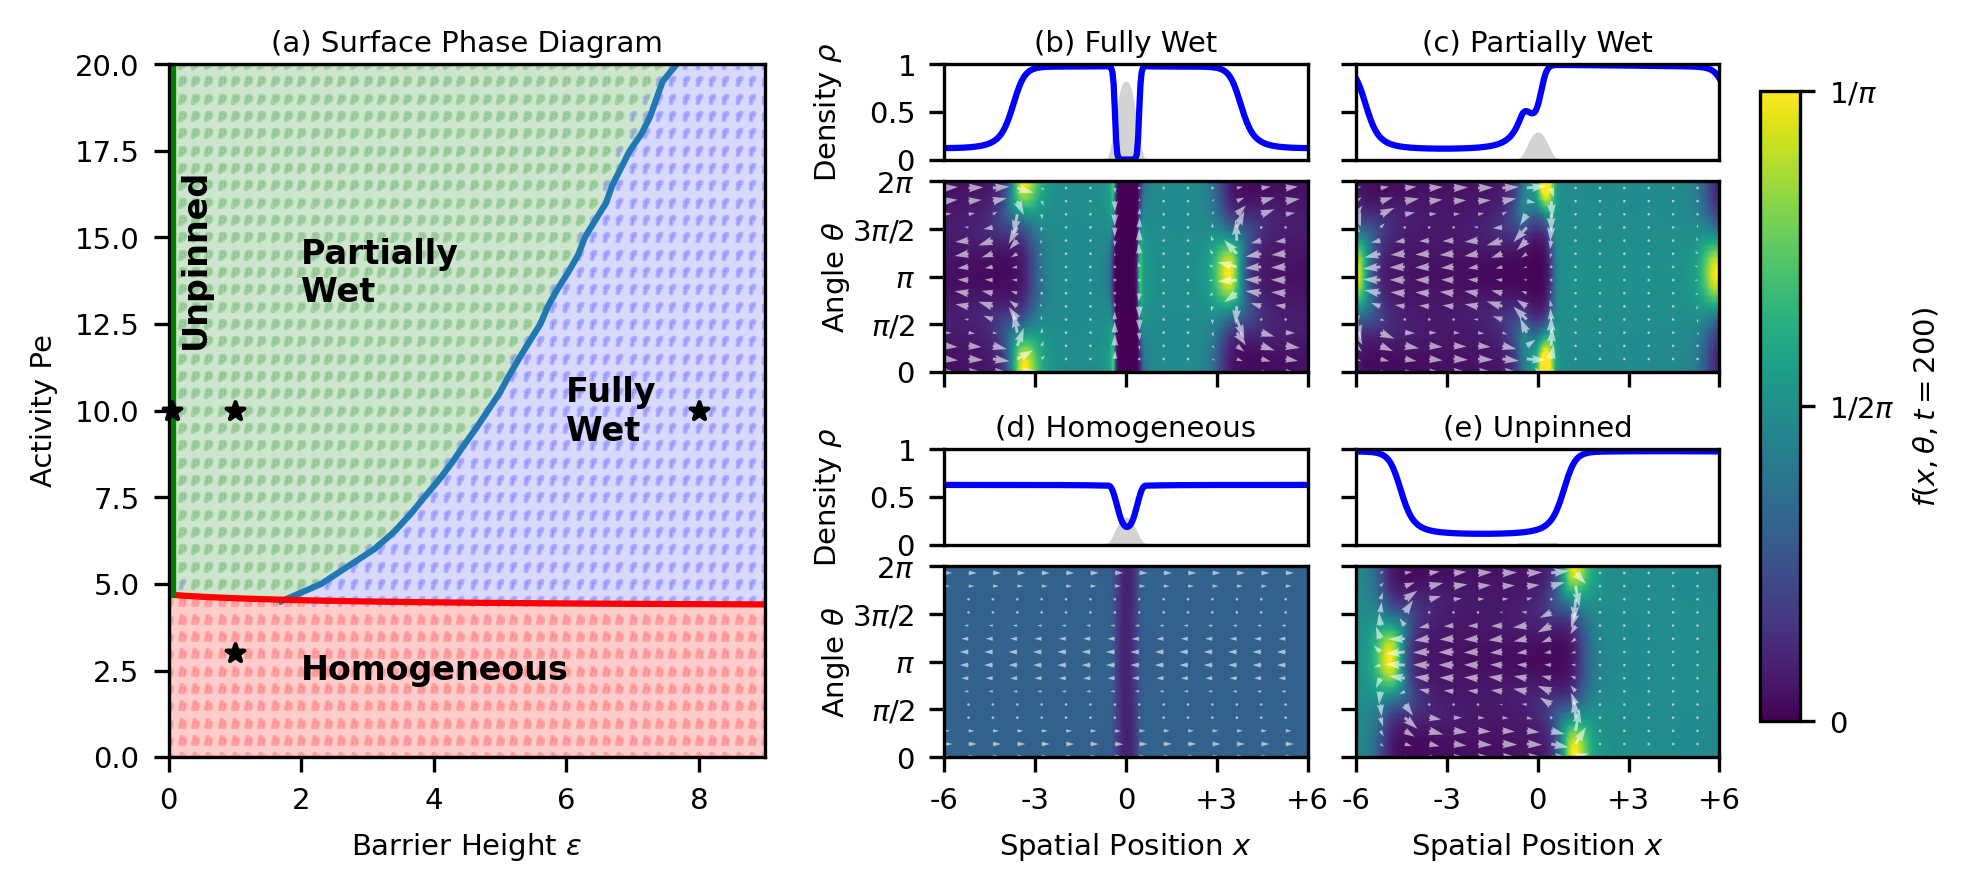

In [10]:
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
mpl.rcParams.update({'font.size': 7})


### PART 1 ###
N_x1, N_x2 = 299, 30  # Grid size
x1 = np.linspace(0, 10, N_x1)
x2 = np.linspace(0, 2*np.pi, N_x2)
X1, X2 = np.meshgrid(x1, x2)

data = np.load('data/heatmap_data.npz', allow_pickle=True)
Us, Vs, heatmaps, rhos, x1, x2 = data['Us'], data['Vs'], data['heatmaps'], data['rhos'], data['x1'], data['x2']

fig, axs = plt.subplots(5, 3, figsize=(6.67, 3.0), gridspec_kw={'height_ratios': [1, 2, 0.35, 1, 2], 'hspace': 0.18, 'wspace': 0.1, 'width_ratios':[2,1,1]}, dpi=300)

# Combine the left column into a single plot
gs = GridSpec(4, 3, figure=fig, height_ratios=[1, 2, 1, 2], hspace=0.15, wspace=-0.2)
combined_ax = fig.add_subplot(gs[:, 0])  # Combine all rows in the first column

states_list = ['Partially Wet', 'Homogeneous', 'Unpinned', 'Fully Wet']
cols_list = ['green', 'red', 'red', 'blue']
shapes = {0: '$p$', 1: '$h$', 2: '$u$', 3: '$f$'}
for state in set(classification_list):
    indices = [i for i, c in enumerate(classification_list) if c == state]
    plt.scatter(epsilons[indices], Pe[indices], label=states_list[state], marker=shapes[state], s=3, alpha=0.2, color=cols_list[state])

combined_ax.set_xlabel(r'Barrier Height $\epsilon$')
combined_ax.set_ylabel('Activity Pe')
#combined_ax.text(0.02, 0.98, '(a)', transform=combined_ax.transAxes, fontsize=8, va='top')

FW_epsilons = np.concatenate(([1.7, 2.3, 2.7, 3.1, 3.4], critical_vals[2:], [10]))
FW_Pes = np.concatenate((np.linspace(4.5, 20.0, 32), [100]))
combined_ax.plot(FW_epsilons, FW_Pes, label='Wetting Transition')
x = np.linspace(0, 10, 500)
y_1 = 4.33 + 0.9/(x+2.5)
combined_ax.plot(x, y_1, label='Phase Separation', color='red')
combined_ax.set_xlim(0, 9)
combined_ax.set_ylim(0, 20)
combined_ax.vlines(0.05, 4.6, 20, color='green', label='Drying Transition', linewidth=2)
#combined_ax.legend(loc='upper right')

combined_ax.fill_between(x, 0, y_1, color='red', alpha=0.2)
combined_ax.fill_between(FW_epsilons, 4.33+0.9/(FW_epsilons+2.5), FW_Pes, color='blue', alpha=0.15)
#combined_ax.fill_between(FW_epsilons, FW_Pes, 20+0*FW_Pes, color='green', alpha=0.2)

FW_epsilons_fill = np.concatenate((np.linspace(0, 1.8, 100), FW_epsilons))
FW_Pes_min = np.concatenate((4.33 + 0.9/(np.linspace(0, 1.8, 100)+2.5), FW_Pes))
FW_Pes_max = 20.0 + 0*FW_Pes_min
combined_ax.fill_between(FW_epsilons_fill, FW_Pes_min, FW_Pes_max, color='green', alpha=0.2)

combined_ax.text(2.0, 15, 'Partially \nWet', fontsize=8, va='top', weight='bold')
combined_ax.text(6.0, 11, 'Fully \nWet', fontsize=8, va='top', weight='bold')
combined_ax.text(2.0, 3, 'Homogeneous', fontsize=8, va='top', weight='bold')
combined_ax.text(0.15, 17, 'Unpinned', fontsize=8, va='top', weight='bold', rotation=90)

posns = [[8.0, 1.0, 1.0, 0.05], [10, 10, 3, 10]]
combined_ax.scatter(posns[0], posns[1], marker='*', color='black', s=20, zorder=10, clip_on=False)
combined_ax.set_title('(a) Surface Phase Diagram', fontsize=7, pad=3)

# Remove the individual axes in the left column
for i in range(5):
    fig.delaxes(axs[i, 0])

### PART 2 ###
axs[2, 1].set_visible(False)
axs[2, 2].set_visible(False)
axs = np.array([[combined_ax, axs[0, 1], axs[0, 2]],
                [None, axs[1, 1], axs[1, 2]],
                [None, axs[3, 1], axs[3, 2]], 
                [None, axs[4, 1], axs[4, 2]]], dtype=object)


labels = ['(b) Fully Wet', '(c) Partially Wet', '(d) Homogeneous', '(e) Unpinned']
for i in [0, 1]:
    for j in [0, 1]:
        number = 2*i + j
        U, V = Us[number], Vs[number]
        rho = rhos[number]
        heatmap_data = heatmaps[number]

        ax1 = axs[2*i, j+1]
        #ax1.text(0.01, 0.95, labels[number], transform=ax1.transAxes, fontsize=8, va='top')
        
        x = np.linspace(4.5, 5.5, 500)
        if i == 1 and j == 1:
            ax1.fill_between(x, 0*x, 0.00 * (np.cos((x-5)*np.pi/0.5)+1), color='lightgrey')
        elif i == 0 and j == 0:
            ax1.fill_between(x, 0*x, 0.4 * (np.cos((x-5)*np.pi/0.5)+1), color='lightgrey')
        else:
             ax1.fill_between(x, 0*x, 0.4/3 * (np.cos((x-5)*np.pi/0.5)+1), color='lightgrey')

        ax1.plot(x1, rho[:-1], color='blue')
        ax1.set_xlim(0, 10)
        ax1.set_xticks([])
        ax1.set_ylim(0, 1)
        ax1.set_yticks(np.arange(0, 1.5, 0.5))
        ax1.set_yticklabels([r'$0$', r'$0.5$', r'$1$'])
       

        ax2 = axs[2*i+1, j+1]
        im = ax2.imshow(heatmap_data, extent=[0, 10, 0, np.pi], origin='lower', cmap='viridis', alpha=1.0, aspect='auto', vmin = 0.0, vmax = 1/np.pi)
        x_skip = 2
        y_skip = 20
        ax2.quiver(X1[::x_skip, ::y_skip], X2[::x_skip, ::y_skip]/2, U[::x_skip, ::y_skip], V[::x_skip, ::y_skip], color='white', width=0.008, alpha=0.6, scale=3)
        ax2.set_yticks(np.arange(0, np.pi+np.pi/4, np.pi/4))
        if j == 0:
            ax2.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
            ax1.set_yticklabels([r'$0$', r'$0.5$', r'$1$'])
            
            
        else:
            ax2.set_yticklabels([])
            ax1.set_yticklabels([])
        
        ax2.set_xticks([0, 2.5, 5, 7.5, 10])
        ax1.set_title(labels[number], fontsize=7, pad=3)
        if i == 1:
            ax2.set_xticklabels([r'-6', r'-3', r'0', r'+3', r'+6'])
        elif i == 0:
            ax2.set_xticklabels([])
        ax2.set_ylim(0, np.pi)
        
        for ax in axs[-1, 1:]:
            ax.set_xlabel(r'Spatial Position $x$')

        for ax in axs[::2, 1]:
            ax.set_ylabel(r'Density $\rho$', labelpad=6)
        for ax in axs[1::2, 1]:
            ax.set_ylabel(r'Angle $\theta$', labelpad=0)

# Add a large color bar on the right-hand side
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([0, 1/(2*np.pi), 1/np.pi])
cbar.set_ticklabels([r'$0$', r'$1/2\pi$', r'$1/\pi$'])
cbar.set_label(r'$f(x, \theta, t=200)$')

plt.tight_layout(pad=0.0)
#plt.savefig('fig_phase_diagram_alternative.pdf', bbox_inches='tight')